<a href="https://colab.research.google.com/github/eliottpark/BIOE145/blob/main/NeuralNetsMalaria_Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6: Neural Networks


## 1. Backpropagation - Essentials

As you examined in class, a simple layer in a feedforward neural network can be expressed as the following:

$$h = Wx + b$$

$$t = \sigma(h) = \begin{cases}0, &\text{if $h<0$}\\h,& \text{otherwise}\end{cases}$$

$$\mathcal{L} = \frac{1}{2}(y - t)^2$$

where $x$ is the input, $W$ is the weight matrix at this node, $b$ is the bias added at the node, $\sigma(\cdot)$ is the activation function, $y$ is the label, and $\mathcal{L}$ is the loss.

The activation function and the loss function (squared loss used here) are choices made when creating a neural network. 


### a. What are the unknowns in the problem?
$W, b$

### b. What do we want minimize?

$\mathcal{L}$

### c. What method could we use to find the unknowns?

Backpropogation.
Backprop unknowns: $\frac{d\mathcal{L}}{dx}$, $\frac{d\mathcal{L}}{dW}$, $\frac{d\mathcal{L}}{db}$, $\frac{d\mathcal{L}}{dy}$

### d. Find the partial derivatives of L with respect to the unknowns. 

Assume we use ReLU for the activation function.

$$\frac{d\mathcal{L}}{dt} = t-y =\begin{cases}0, &\text{if $Wx + b<0$}\\Wx + b - y,& \text{otherwise}\end{cases}$$
$$\frac{d\mathcal{L}}{dy} = y-t =\begin{cases}0, &\text{if $Wx + b<0$}\\y - Wx - b ,& \text{otherwise}\end{cases}$$

$$$$

$$\frac{dt}{dh} = \begin{cases}0, &\text{if $t<0$}\\1,& \text{otherwise}\end{cases}$$

$$$$

$$\frac{dh}{dx} = W$$
$$\frac{dh}{dW} = x$$
$$\frac{dh}{db} = 1$$

$$$$

$$\frac{d\mathcal{L}}{dx} = \frac{dh}{dx}\frac{dt}{dh}\frac{d\mathcal{L}}{dt} = \begin{cases}0, &\text{if $t<0$}\\W(t-y),& \text{otherwise}\end{cases} = \begin{cases}0, &\text{if $Wx + b<0$}\\W^2x + Wb - Wy,& \text{otherwise}\end{cases}$$
$$$$
$$\frac{d\mathcal{L}}{dW} = \frac{dh}{dW}\frac{dt}{dh}\frac{d\mathcal{L}}{dt} = \begin{cases}0, &\text{if $t<0$}\\x(t-y),& \text{otherwise}\end{cases} = \begin{cases}0, &\text{if $Wx + b<0$}\\Wx^2 + bx - yx,& \text{otherwise}\end{cases}$$
$$$$
$$\frac{d\mathcal{L}}{db} = \frac{dh}{db}\frac{dt}{dh}\frac{d\mathcal{L}}{dt} = \begin{cases}0, &\text{if $t<0$}\\t-y,& \text{otherwise}\end{cases}=\begin{cases}0, &\text{if $Wx + b<0$}\\Wx + b - y,& \text{otherwise}\end{cases}$$

## 2. Backpropogation

A neural network is regarded as compositional, in that the output of one layer feeds in as the input to the next layer. Using the the same notation as above but ignoring the bias $b$ for simplicity:

$$t = \sigma_L(W_L \sigma_{L-1}(...\sigma_2(W_2 \sigma_1(W_1x))...))$$

Here $x$ is the original input data, and $t$ is the output of the neural network.

Even more simply, we can look at each layer L:

$$N_1\rightarrow N_2\rightarrow N_3\rightarrow ... N_{L-1}\rightarrow N_L $$

The idea here is the same - we will need to solve for partial derivatives for each layer to set the unknowns. As the previous layer feeds into the next, you can only solve for a Jacobian (vector of partials) one wrt one layer down e.g. we can first solve for

$$ J_{N_L} (N_{L-1})$$

the Jacobian of $N_L$ with respect to $N_{L-1}$

### a. For the above simple representation, write out the Jacobian of the the final layer with respect to the first layer.

$$ J_{N_L} (N_{1}) = J_{N_L} (N_{L-1}) * J_{N_L-2} (N_{L-2}) *...*J_{N_2} (N_{1})$$

### b. Based on the equation you've described above, explain using time or space complexity why the best way to solve for the gradient in 2a. is to work backwards.

The equation above shows us that we are able to find the gradient at some layer, it is sufficient to compute the jacobian at that layer with respect to the next layer downstream and apply chain rule to the loss at the next layer. Thus, we can start at the last layer's loss and compute gradient at each previous layer by just multiplying the jacobian at each layer with the loss at the next. This reduces our computational complexity by going from O(N!m) to O(Nm) with the assumtion that computing the jacobian at a given layer costs O(m).

## 3. Simple Neural Network

Here you'll try out writing a neural network for a simple classification problem. For full credit, the final test accuracy should be above 0.6.

The dataset is of cell images from thin blood smear slides of segmented cells, with labels indicating the presence of malaria.

Source: https://lhncbc.nlm.nih.gov/publication/pub9932

Paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6544011/

Some setup to start with:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow import keras
import tensorflow_datasets as tfds

In [ ]:
# comment out following line if tf.__version__ > 1.x
# tf.enable_eager_execution()

In [ ]:
malaria, info = tfds.load(name="malaria", split="train", with_info=True)
malaria = malaria.shuffle(30000).prefetch(tf.data.experimental.AUTOTUNE)
info

tfds.core.DatasetInfo(
    name='malaria',
    version=1.0.0,
    description='The Malaria dataset contains a total of 27,558 cell images
with equal instances of parasitized and uninfected cells from the thin blood 
smear slide images of segmented cells.',
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=27558,
    splits={
        'train': 27558,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward 
      improved malaria parasite detection in thin blood smear images},
      author={Rajaraman, Sivaramakrishnan and Antani, Sameer K and Poostchi, Mahdieh
      and Silamut, Kamolrat and Hossain, Md A and Maude, Richard J and Jaeger, 
      Stefan and Thoma, George R}

In [ ]:
info

tfds.core.DatasetInfo(
    name='malaria',
    version=1.0.0,
    description='The Malaria dataset contains a total of 27,558 cell images
with equal instances of parasitized and uninfected cells from the thin blood 
smear slide images of segmented cells.',
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=27558,
    splits={
        'train': 27558,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward 
      improved malaria parasite detection in thin blood smear images},
      author={Rajaraman, Sivaramakrishnan and Antani, Sameer K and Poostchi, Mahdieh
      and Silamut, Kamolrat and Hossain, Md A and Maude, Richard J and Jaeger, 
      Stefan and Thoma, George R}

True
True
True
True


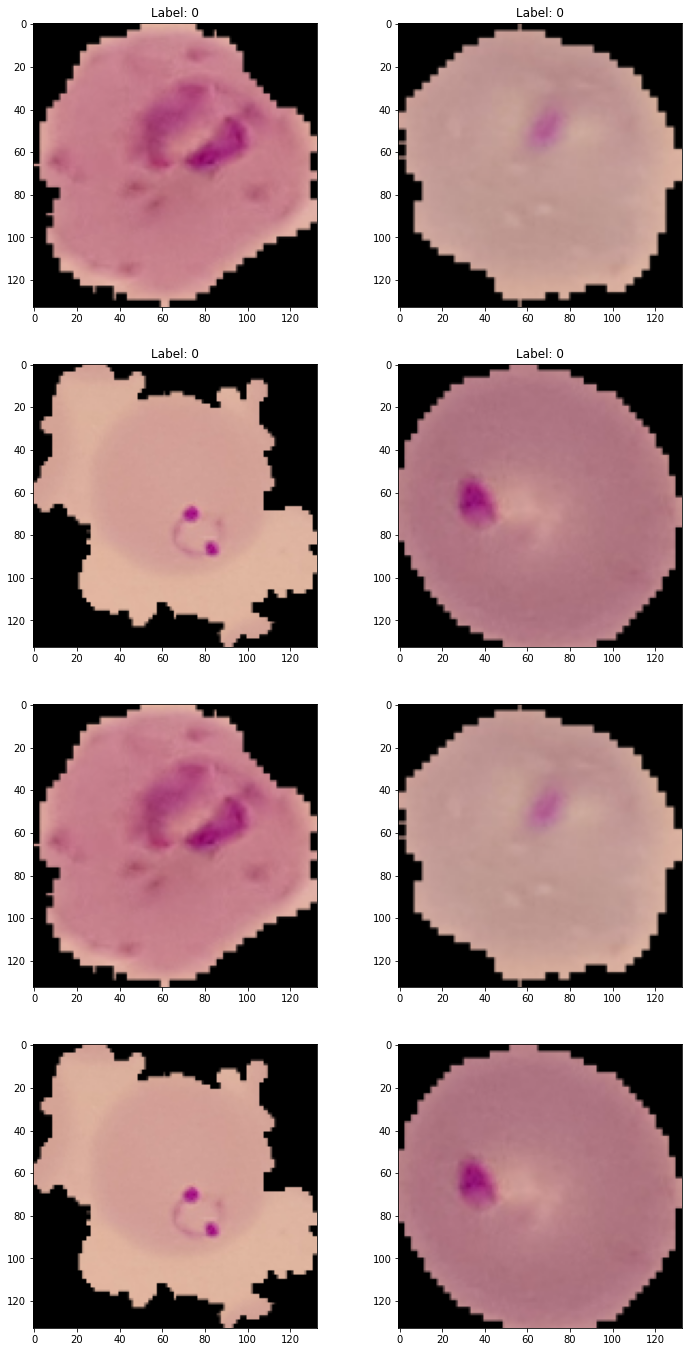

In [ ]:
# Visualize some images
plt.figure(figsize=(12,24))
ex_im = np.zeros((4, 133, 133, 3), dtype=np.uint8)

for i, feature in enumerate(malaria.take(4)):
    image = cv2.resize(feature["image"].numpy(),  (133, 133))
    label = feature["label"].numpy()
    ex_im[i] = image
    print(np.array_equal(ex_im[i], image))
    plt.subplot(4, 2, i+1)
    plt.title("Label: "+str(label))
    plt.imshow(image)
    
for i, image in enumerate(ex_im):
    plt.subplot(4, 2, i+5)
    # plt.title("Label: "+str(label))
    plt.imshow(image)
    # i+=1
plt.show()


### a. Extract some samples from the malaria dataset

Hints:

* Keep the total number of samples small ( < 10000) - it largely depends on your memory (if your notebook starts to crash, reduce the number of samples and try again)
* The dimension of each image is height \* width \* 3, with the 3 representing the number of channels 
* The height and width of the images aren't all the same, so resize all of them to be 133 by 133 (see [cv2.resize](https://medium.com/@manivannan_data/resize-image-using-opencv-python-d2cdbbc480f0))
* The possibles labels are 0s and 1s (scalars)
* Split into a training and testing set (a split like 80:20 train to test is reasonable)


In [ ]:
total_sample_size =  10000

# Normalize to get values between [0,1]
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

# TODO: Initialize to the correct shapes with zeros
train_images = np.zeros((int(total_sample_size*0.8), 133, 133, 3), dtype=np.uint8)
train_labels = np.zeros((int(total_sample_size*0.8)), dtype=np.uint8)
test_images = np.zeros((int(total_sample_size*0.2), 133, 133, 3), dtype=np.uint8)
test_labels = np.zeros((int(total_sample_size*0.2)), dtype=np.uint8)

# TODO: Fill in the splits above
for i, feature in enumerate(malaria.take(total_sample_size)):
  image = cv2.resize(feature["image"].numpy(),  (133, 133))
  label = feature["label"].numpy()

  if i < total_sample_size*0.8:
    train_images[i] = image
    train_labels[i] = label
  else:
    test_images[i - int(total_sample_size*0.8)] = image
    test_labels[i - int(total_sample_size*0.8)] = label


# Normalize values to [0,1]
train_images = rescale(train_images)
test_images = rescale(test_images)]

0.9921569
0.0


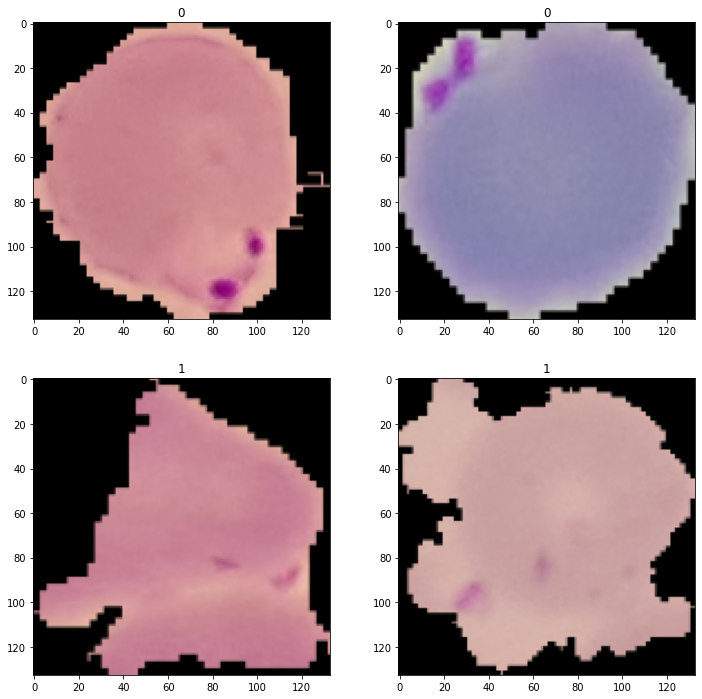

In [ ]:
print(np.max(train_images[100]))
print(np.min(train_images[100]))

plt.figure(figsize=(12,12))
for i in range(4):
  plt.subplot(2, 2, i+1)
  plt.title(train_labels[i])
  plt.imshow(train_images[i])
plt.show()

### b. Add some layers to the model

Hints:

*   See examples of layers in the Keras documentation: https://keras.io/layers/core/
*   For the first layer, provide an input_shape, which refers to the shape of an image from your dataset

See examples at https://www.tensorflow.org/tutorials



In [ ]:
model = keras.Sequential()
# TODO:
model.add(tf.keras.Input(shape=(133, 133, 3)))

model.add(tf.keras.layers.Conv2D(32, 5, strides=2, activation="relu"))
model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(3))

model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(3))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1,  activation='sigmoid'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 65, 65, 32)        2432      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 63, 63, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 19, 19, 32)        9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 17, 17, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)              

### c. Choose how to train the above model

Pick an optimizer, loss function, and metric. If you choose something not covered in class, give a brief explanation and an advantage of your choice.

*   Optimizers: https://keras.io/optimizers/
*   Losses: https://keras.io/losses/
*   Metrics: https://keras.io/metrics/

### Reasoning:

TODO:


In [ ]:
# TODO:
opt = keras.optimizers.Adam(learning_rate=0.0005)
loss_func = tf.keras.losses.BinaryCrossentropy()
metric = [tf.keras.metrics.BinaryAccuracy(), 'accuracy'] 

In [ ]:
model.compile(optimizer=opt,
              loss=loss_func,
              metrics=metric)

### d. Train the model

Choose an appropriate number of epochs (Hint: try some different values)

In [ ]:
# TODO:
num_epochs = 6

history = model.fit(train_images, train_labels, validation_split=0.1, batch_size=64, epochs=num_epochs)

Epoch 1/6
113/113 [==============================] - 84s 737ms/step - loss: 0.6329 - binary_accuracy: 0.6350 - accuracy: 0.6350 - val_loss: 0.5282 - val_binary_accuracy: 0.7937 - val_accuracy: 0.7937
Epoch 2/6
113/113 [==============================] - 88s 779ms/step - loss: 0.4018 - binary_accuracy: 0.8296 - accuracy: 0.8296 - val_loss: 0.2094 - val_binary_accuracy: 0.9212 - val_accuracy: 0.9212
Epoch 3/6
113/113 [==============================] - 86s 758ms/step - loss: 0.2252 - binary_accuracy: 0.9209 - accuracy: 0.9209 - val_loss: 0.1887 - val_binary_accuracy: 0.9488 - val_accuracy: 0.9488
Epoch 4/6
113/113 [==============================] - 84s 740ms/step - loss: 0.1889 - binary_accuracy: 0.9426 - accuracy: 0.9426 - val_loss: 0.1844 - val_binary_accuracy: 0.9438 - val_accuracy: 0.9438
Epoch 5/6
113/113 [==============================] - 84s 741ms/step - loss: 0.1772 - binary_accuracy: 0.9391 - accuracy: 0.9391 - val_loss: 0.1972 - val_binary_accuracy: 0.9400 - val_accuracy: 0.9400


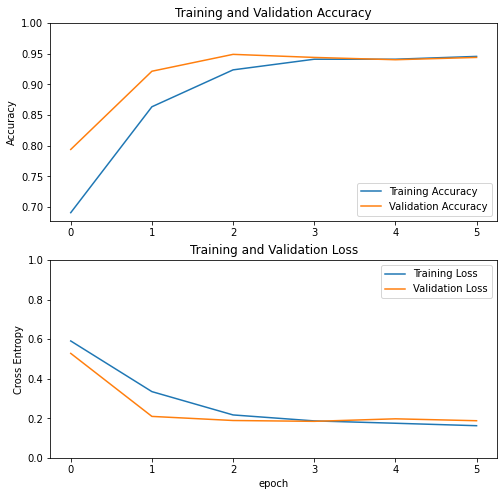

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### e. Evaluate based on the testing set

Must be greater that 0.55 for full credit

In [ ]:
test_loss, test_acc_binary, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy (Binary):', test_acc_binary)
print('\nTest accuracy:', test_acc)

63/63 - 6s - loss: 0.1850 - binary_accuracy: 0.9470 - accuracy: 0.9470

Test accuracy (Binary): 0.9470000267028809

Test accuracy: 0.9470000267028809


### f. Based on the above accuracies between the testing and training sets, did you overfit while training?

No, I do not believe so.


### g. (Extra Credit) Improve your model to achieve an accuracy of greater than 0.70 on the testing set.